## Summary

### 

*Date created: 2022-10-04*

**What problem is addressed in the notebook?**

The aim of this notebook is to show how we can use the Python model *conjugathepriors* to perform a conjugate analysis.

The intention is is that this notebook will become the documentation for *conjugatepriors*.

**Is the problem solved in a single notebook?** \

Yes.
I did originally spec these for a series of notebooks, but I decided against it.
All the `Prior` classes in *conjugatepriors* share the same interface, and so, whilst they did cover every last part the module, the notebooks were essentially duplicates of each other that added little.
Besides that, I did not plan for the notebooks to be theoretical or act as tutorials for conjugate analyses, so having full coverage for each `Prior` subclass was unneeded, as a workflow should work for each of the classes.

**Did you do anything novel in the notebook?** \

Only in the sense this is the first time I showed off the intended end-to-end use of the `Prior` class. 

**Is there anything you have done for the first time?** \

I did not not want to overburden the module with plotting functions, so I defined some recipes to help with plotting.

:::{.callout-note}
I still need to document the functions and added them to my cookbook.
:::

**References**

- [ConjugatePriors](https://github.com/ljk233/ConjugatePriors.py)
- M249 Book 4, *Bayesian Statistics*
- [SciPy, scipy.stats.rv_discrete](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_discrete.html)

### To-do

- [ ] Write the API
   - [X] `Prior`
   - [X] `Beta`
   - [X] `Gamma`
   - [ ] `Normal`
   - [ ] `credible_interval(prior)`
   - [ ] `describe_model(prior)`
   - [ ] `plot_models(*priors)`
   - [ ] `sample_fit(prior, *args)`
- [ ] Cookbook
   - [X] From prior beliefs
   - [X] From past observations
   - [X] Using a Uniform prior
   - [ ] Sampling a fitted model

### History

- 2022-10-08
   - Added an example for using a Uniform prior
- 2022-10-07
   - Added the API for the Beta and Gamma priors
   - Added an example for starting from prior observation
- 2022-10-04
   - Note initialised
   - Wrote the API for the Prior
   - Added an example for starting with prior beliefs

## API

### Prior


A stub class that defines an interface for the data model.
All other classes inherit for `Prior`.
The intention is for `Prior` to be a term to represent its collection of subclasses.

> ##### `Prior()`

Initialise and return an instance of `Prior`.

#### Properties

> ##### `model: str.rv_contrinuous (read-only)`

The likelihood distribution of $\theta$, the modelled parameter.

##### Class methods

> #### `from_belief(mode: float, lower: float, upper: float, spread: float) -> Prior`

Return an initialised prior based on some belief about the location of  $\theta$.

Arguments

- *mode*, the likely value of the  $\theta$
- *lower*, lower value of the equal-tailed 100(1-$\alpha$)% interval of $\theta$
- *lower*, upper value of the equal-tailed 100(1-$\alpha$)% interval of $\theta$
- *alpha*, alpha value in the 100(1-$\alpha$)%  interval

Preconditions

- *mode*, *lower*, *upper* are valid values of $\theta$
- *lower* < *mode* < *upper*
- 0 < *alpha* < 1

> ##### `from_obs(arr: ArrayLike) -> Prior`

Return an initialised prior based on some prior observations of the fitted model.

Preconditions

- len(*arr*) >= 1
- Every element of *arr* are integer or float values

#### Methods

> ##### `fit() -> st.rv_continuous | st.rv_discrete`

Return the paired fitted distribution, based on the most likely location of $\theta$.

> ##### `is_uniform() -> bool`

Return true if self is an improper prior. Otherwise false.

An improper prior is akin Uniform distribution with one of both of the values being equal to $\pm \infty$.

> ##### `to_posterior(arr: ArrayLike) -> Prior`

Return a new instance of the prior, with its model of the likelihood distribution of $\theta$ updated to take into account the given array of observations.

Preconditions

- len(*arr*) >= 1
- Every element of *arr* are integer or float values

### Beta(Prior)

A class to represent the use of a beta conjugate prior.

It's `model` is the likelihood distribution of $\theta$, the probability of success in a single Bernoulli trial, where $\theta \sim \text{beta}(a, b)$.

It `fits` a binomial random variable $b$, where $b \sim B(n, \theta)$.

#### Initialisation

> ##### `Beta(a: float = 1.0, b: float = 1.0)`

Initialise and return an instance of `Beta`.

Passing no arguments will return a uniform likelihood distribution for $\theta : \theta \sim U(0, 1)$.

#### Class methods

> ##### `from_obs(arr: ArrayLike) -> Prior`

Return an initialised instance of Beta based on some prior observations of the fitted model.

Preconditions

- len(*arr*) >= 1
- *arr*[*i*] == 0 or *arr*[*i*] == 1, where 0 represent a failures and 1 represents a failure, for 0 <= *i* <= len(*arr*)

#### Methods

> ##### `fit(n: int) -> st.rv_discrete`

Return the paired fitted distribution, based on the most likely location of $\theta$.

Given a beta prior models *p* in a binomial distribution, *n* represents the number of observations.
Thus the fitted model is $b \sim B(n, \theta)$

> ##### `to_posterior(arr: ArrayLike) -> Prior`

Return a new instance of the Beta, with its likelihood distribution of $\theta$ updated to take into account the given array of observations.

Preconditions

- len(*arr*) >= 1
- *arr*[*i*] == 0 or *arr*[*i*] == 1, where 0 represent a failures and 1 represents a failure, for 0 <= *i* <= len(*arr*)

### Gamma(Prior)

A class to represent the use of a gamma conjugate prior.

It's `model` is the likelihood distribution of $\theta$, some parameter which may only take non-negate values.

It `fits` a Poisson random variable $p$, where $p \sim \text{Poisson}(\theta)$.

#### Initialisation

> ##### `Gamma(a: float = 0.0, b: float = 0.0)`

Initialise and return an instance of `Gamma`.

Passing no arguments will return a uniform likelihood distribution for $\theta : \theta \sim U(0, \infty)$.

## Cookbook

### Dependencies

In [1]:
import conjugatepriors as cp
import numpy as np
import pandas as pd
from scipy import stats as st
import seaborn as sns

In [2]:
np.set_printoptions(precision=6)
sns.set_theme()

In [3]:
%load_ext watermark
%watermark --iv

numpy          : 1.23.3
conjugatepriors: 0.2.0
pandas         : 1.5.0
scipy          : 1.9.1
seaborn        : 0.12.0



### Functions

In [4]:
# get the end points of rv, or approximate them
def get_minmax(rv):
    # get the end points
    a, b = rv.a, rv.b
    # are either of the end-points undefined?
    if a == -np.inf:
        a = rv.ppf(0.001)
    if b == np.inf:
        b = rv.ppf(0.999)
    return a, b

In [5]:
# return rv's PMF as a pandas DataFrame
def pmf(rv, label, step=1):
    a, b = get_minmax(rv)
    # return the DataFrame
    xs = np.arange(a, b + 1, step=step, dtype=int)
    return (
        pd.DataFrame()
        .assign(
            model=[label] * len(xs),
            variable=xs,
            value=rv.pmf(xs)
        )
    )

### 1. Using a beta prior from a prior belief

> *A University tutor believe the pass rate of their course is approximately 75%, but could be between 70-80%.*

#### Initialise the prior likelihood.

In [6]:
beta_prior = cp.Beta.from_belief(0.75, 0.70, 0.80)

#### Inspect the prior likelihood

:::{.callout-tip}
Printing the instance will return a description of the beta likelihood distribution.
:::

In [7]:
print(beta_prior)

Beta(25.51, 9.17)


Get the 99% credible interval.

In [8]:
cp.credible_interval(beta_prior, alpha=0.01)

array([0.525597, 0.896076])

:::{.callout-note}
The `describe_model()` functions returns a *pandas* `Series`.
:::

Output a description of the likelihood distribution.

In [9]:
cp.describe_model(beta_prior)

median    0.740154
var       0.005450
lcb       0.579364
ucb       0.866115
dtype: float64

Plot the prior likelihood of $\theta$.

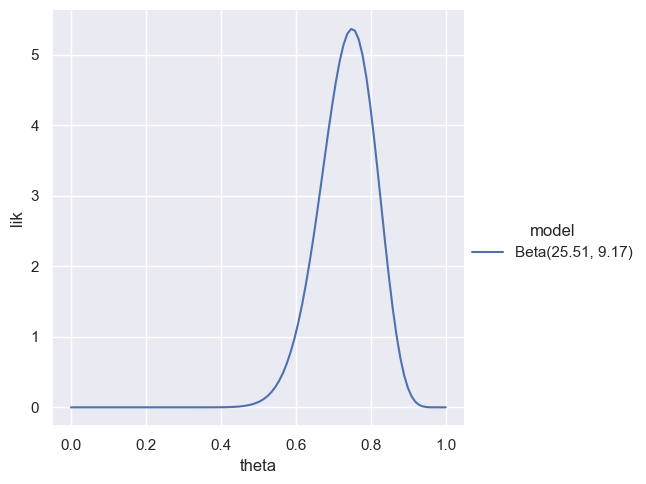

In [10]:
cp.plot_models(beta_prior)

#### From prior to posterior....

> A year has passed, and the tutor observes that 14 out of the 25 students pass the course at first attempt.

Update the prior with the findings.

:::{.callout-tip}
If you have the summarised observations, simply convert them to a list of 01s.
:::

In [11]:
beta_post = beta_prior.to_posterior([0] * 14 + [1] * 11)

In [12]:
print(beta_post)

Beta(36.51, 23.17)


How has the tutor's belief changed?

How has the tutor's beliefs about the pass rate of the course changed with the observations?

Compare descriptions of the prior and posterior.

In [13]:
(pd.DataFrame()
 .assign(
     prior=cp.describe_model(beta_prior),
     posterior=cp.describe_model(beta_post)
 )
)

,prior,posterior
median,0.740154,0.613031
var,0.005450,0.003914
lcb,0.579364,0.486094
ucb,0.866115,0.730355


Compare the prior and posterior likelihood distributions graphically.

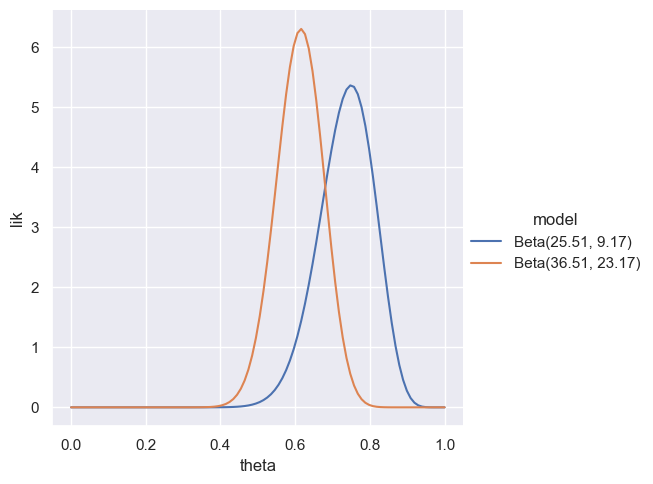

In [14]:
cp.plot_models(beta_prior, beta_post)

:::{.callout-tip}
**Recipe**
:::


How do the fitted distributions compare?

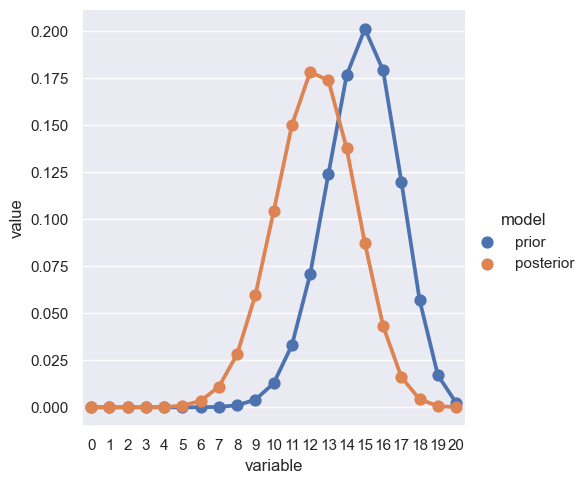

In [15]:
priors = [beta_prior, beta_post]
labels = ['prior', 'posterior']

gs = pd.concat(
    [pmf(prior.fit(20), label) for prior, label in zip(priors, labels)]
)
sns.catplot(data=gs, x='variable', y='value', hue='model', kind='point')

### 2. Using a gamma prior from prior observations

> *A person is interested in the number of birds that fly by their window each hour.*
*They keep track of the number for six hours.*

#### Initialise the prior likelihood

In [16]:
gamma_prior = cp.Gamma.from_obs([5, 7, 3, 2, 4, 4])

#### Inspect the prior likelihood

:::{.callout-tip}
Printing the instance will return a description of the beta likelihood distribution.
:::

In [17]:
print(gamma_prior)

Gamma(25.00, 6.00)


Get the 99% credible interval.

In [18]:
cp.credible_interval(gamma_prior, alpha=0.01)

array([2.332562, 6.624165])

:::{.callout-note}
The `describe_model()` functions returns a *pandas* `Series`.
:::

Output a description of the likelihood distribution.

In [19]:
cp.describe_model(gamma_prior)

median    4.111245
var       0.694444
lcb       2.696447
ucb       5.951683
dtype: float64

Plot the prior likelihood of $\theta$.

In [20]:
gamma_prior.model.b == np.inf

True

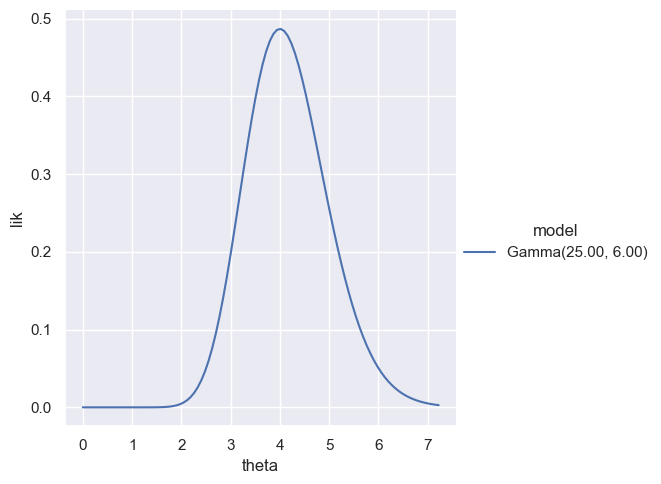

In [21]:
cp.plot_models(gamma_prior)

#### From prior to posterior....

> *The person counts the birds the next day for the same six hours.*
*They update their prior with the new observations.*

In [22]:
gamma_post = gamma_prior.to_posterior([1, 2, 2, 1, 2, 3])

In [23]:
print(gamma_post)

Gamma(36.00, 12.00)


How has the tutor's belief changed?

How has the tutor's beliefs about the pass rate of the course changed with the observations?

Compare descriptions of the prior and posterior.

In [24]:
(pd.DataFrame()
 .assign(
     prior=cp.describe_model(gamma_prior),
     posterior=cp.describe_model(gamma_post)
 )
)

,prior,posterior
median,4.111245,2.972268
var,0.694444,0.250000
lcb,2.696447,2.101163
ucb,5.951683,4.056377


Compare the prior and posterior likelihood distributions graphically.

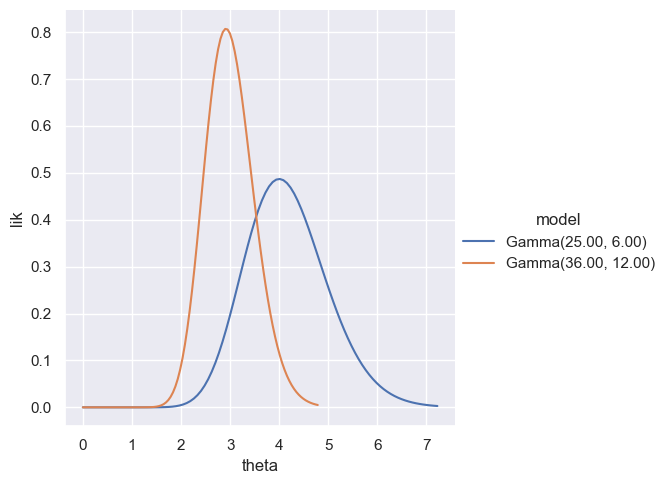

In [25]:
cp.plot_models(gamma_prior, gamma_post)

:::{.callout-tip}
**Recipe**
:::


How do the fitted distributions compare?

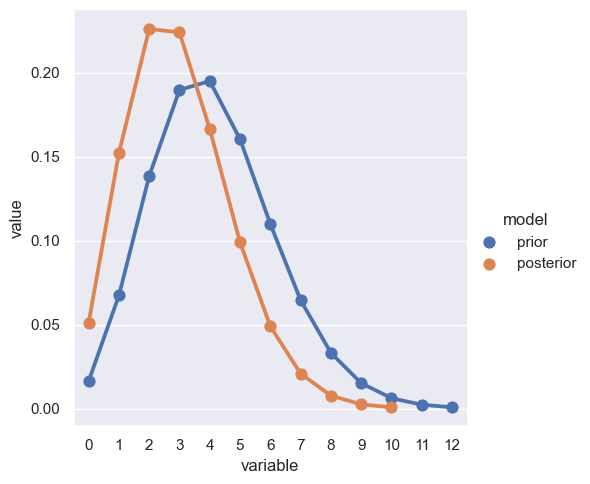

In [26]:
priors = [gamma_prior, gamma_post]
labels = ['prior', 'posterior']

gs = pd.concat(
    [pmf(prior.fit(), label) for prior, label in zip(priors, labels)]
)
sns.catplot(data=gs, x='variable', y='value', hue='model', kind='point')

### 3. Using a uniform prior

> *An amateur myrmecologist has been asked to provide an estimate of the expected size (in cm) of ant hills in the local area.*
*They are told that other studies have shown that the variance is 10 (sq. cm).*

#### Initialise the prior likelihood

In [27]:
normal_prior = cp.Normal(10)

#### Inspect the prior likelihood

Is it a uniform prior?

In [28]:
normal_prior.is_uniform()

True

#### From prior to posterior....

> *The myrmecologist travels to the local park and measures the hights of 12 ant hills....*

:::{.callout-note}
We cheat a bit here and sample a normal rv.
:::

In [29]:
normal_post = normal_prior.to_posterior(st.norm.rvs(40, 64, size=12))

In [30]:
normal_post.is_uniform()

False

In [31]:
print(normal_post)

Normal(22.43, 12.00)


How has the myrmecologist's belief changed?

In [32]:
cp.describe_model(normal_post)

median    22.432831
var       12.000000
lcb       15.643316
ucb       29.222345
dtype: float64

Plot the likelihood distribution for the expected height.

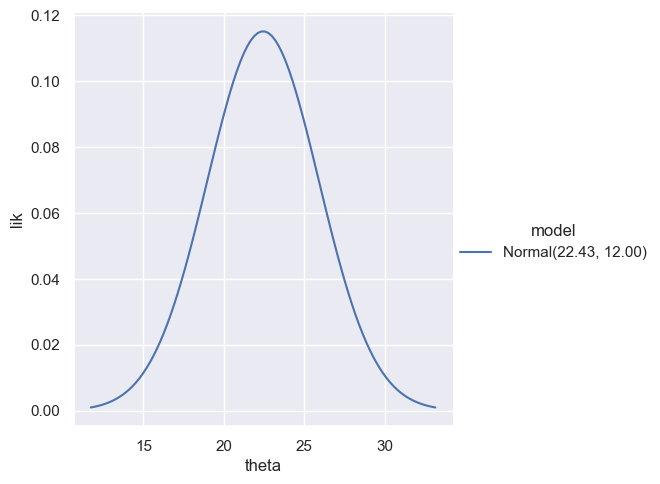

In [33]:
cp.plot_models(normal_post)

:::{.callout-tip}
**Recipe**
:::

How would this look if we were to fit it to 15 ant hills?

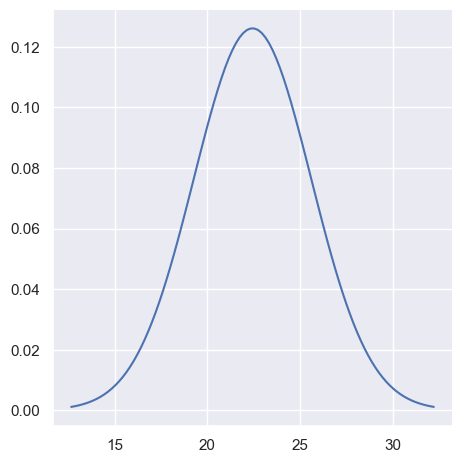

In [34]:
fitted = normal_post.fit()
x = np.linspace(fitted.ppf(0.001), fitted.ppf(0.999), 100)
sns.relplot(x=x, y=fitted.pdf(x), kind='line')